In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import datetime

In [3]:
dat=pd.read_csv('NASDAQOMX-NDX.csv')


In [4]:
dat=dat.iloc[::-1]
dat.dropna(inplace=True)
dat = dat.reset_index(drop = True)

In [5]:
date = dat[['Trade Date']]
dat.drop('Trade Date',inplace=True,axis=1)
dat=pd.concat([date,dat],axis=1)
dat['Trade Date'] = pd.to_datetime(dat['Trade Date'],format='%Y-%m-%d')


In [6]:
dat

,Trade Date,Index Value,High,Low,Total Market Value,Dividend Market Value
0,2003-01-21,1008.93,1028.32,1008.93,1.460069e+09,0.000000e+00
1,2003-01-22,1027.08,1027.08,1003.58,1.487074e+09,3.916400e+04
2,2003-01-23,1039.16,1039.16,1011.12,1.504572e+09,0.000000e+00
3,2003-01-24,992.85,1027.70,992.85,1.437518e+09,0.000000e+00
4,2003-01-27,982.02,1006.26,982.02,1.421834e+09,0.000000e+00
...,...,...,...,...,...,...
4283,2020-01-29,9101.61,9153.08,9067.29,1.020878e+13,0.000000e+00
4284,2020-01-30,9136.09,9140.69,9019.72,1.024745e+13,1.093722e+09
4285,2020-01-31,8991.51,9170.22,8961.59,1.008529e+13,2.465011e+08
4286,2020-02-03,9126.23,9148.50,9031.07,1.023640e+13,0.000000e+00


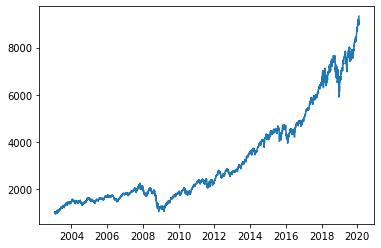

In [7]:
plt.plot(dat['Trade Date'],dat["Index Value"])

In [8]:
def typical(high,low,close,volume):
    mf = ((high + low + close)/3)*volume
    return mf     

In [9]:
#EMA
def EMA(data):
    dats = data.astype(float)
    data['EMA'] = dats.ewm(span = 20).mean()
    return data['EMA']

In [10]:
def MFI(data):
    data = pd.DataFrame(data)
    returns = data - data.shift(1)
    returns.dropna()
    up,down = returns.copy(),returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    
    mfi = 100 - (100/(1+(upm/downm)))
    return mfi

In [11]:
#RSI
def RSI(data):
    data = pd.DataFrame(data)
    returns = data - data.shift(1)
    returns.dropna()
    up,down = returns.copy(),returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    rsi = 100 - (100/(1+(upm/downm)))
    return rsi 

In [12]:
def MACD(ema):
    high = 0.075 * ema
    low = 0.15 * ema
    macd = high - low
    return macd

In [19]:
def Oscillator(data):

    curr = data.iloc[-1]
    data = list(data)
    high = max(data)
    low = min(data)
    so = ((curr - low)/(high - low))*100 
    return so

In [20]:
dat['MF'] = typical(dat['High'],dat['Low'],dat['Index Value'],dat['Total Market Value'])

In [21]:
dat['EMA'] = EMA(dat.iloc[:,[3]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
dat['RSI'] = dat['Index Value'].rolling(7).apply(RSI)

In [23]:
dat['MFI'] = dat['MF'].rolling(7).apply(MFI)

In [24]:
dat['SO'] = dat['Index Value'].rolling(7).apply(Oscillator)

In [25]:
dat.index=date["Trade Date"]

In [26]:
dat['MACD'] = MACD(dat.iloc[:,[7]])

In [27]:
dat['MACD_Signal'] = MACD(dat.iloc[:,[11]])

In [28]:
dat.drop(['High','Low','Total Market Value','Dividend Market Value','MF','MACD_Signal'],axis = 1,inplace = True)

In [29]:
dat.drop("Trade Date",axis=1,inplace=True)

In [30]:
xdata = dat.dropna()

In [31]:
dates = xdata.copy()

In [32]:
#xdata= dates.copy()

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xdata = pd.DataFrame(scaler.fit_transform(xdata))

In [34]:
xdata = xdata.rename({0:'Index Value',1:'EMA',2:'RSI',3:'MFI',4:'SO',5:'MACD'},axis = 1)

In [35]:
xdata.index = dates.index

In [36]:
ydata = xdata['Index Value'].shift(-1)

In [37]:
xdata = xdata.drop('Index Value',axis = 1)

In [38]:
x_trains, y_trains = xdata[:3000],ydata[:3000]

In [39]:
y_trains = pd.DataFrame(y_trains)

In [40]:
x_tests, y_tests = xdata[3000:],ydata[3000:]

In [41]:
y_tests = pd.DataFrame(y_tests)

In [42]:
y_tests.dropna(inplace = True)

In [43]:
x_tests  = x_tests[:-1]

In [44]:
xdata  = xdata[:-1]

In [45]:
ydata.dropna(inplace = True)

In [46]:
from __future__ import division
import random
import math
import time

In [47]:
"""Least Squares Support Vector Regression."""
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels
from scipy.sparse import linalg


class LSSVR(BaseEstimator, RegressorMixin):
    def __init__(self, C=None, kernel=None, gamma=10,polyconst=1,degree=2):
        self.supportVectors      = None
        self.supportVectorLabels = None
        self.C = C
        self.polyconst = float(1)
        self.gamma = gamma
        self.degree = degree
        self.kernel= kernel
        self.idxs  = None
        self.K = None
        self.bias = None 
        self.alphas = None
            

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x_train, y_train):
        
        if type(self.idxs) == type(None):
            self.idxs=np.full(x_train.shape[0],True, dtype=bool)
            
             
        self.supportVectors      = x_train.loc[self.idxs, :]
        self.supportVectorLabels = y_train.loc[self.idxs]
               
        K = self.kernel_func(self.kernel, x_train, self.supportVectors, self.gamma)
        
        self.K = K
        OMEGA = K
        OMEGA[self.idxs, np.arange(OMEGA.shape[1])] =OMEGA[self.idxs, np.arange(OMEGA.shape[1])] + 1/self.C
        
        D = np.zeros(np.array(OMEGA.shape) + 1)
        D[1:,1:] = OMEGA
        D[0, 1:] += 1
        D[1:,0 ] += 1

        n = len(self.supportVectorLabels) + 1
        t = np.zeros(n)
        #t = pd.DataFrame(t)                      #Comment this line while running main function, nd run this block again uncommenting this line when running optimizer fn. 
        t[1:n] = self.supportVectorLabels.values
    
    
        try:
            z = linalg.lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t.ravel()

        self.bias   = z[0]
        self.alphas = z[1:]
        self.alphas = self.alphas[self.idxs]

        return self

    def predict(self, x_test):
        K = self.kernel_func(self.kernel, x_test, self.supportVectors, self.gamma)

        return (K @ self.alphas) + self.bias
    
    def kernel_func(self, kernel, u, v, gamma):
        if kernel == 'linear':
            k = np.dot(u, v.T)
        if kernel == 'rbf':
            k = rbf_kernel(u, v, gamma=gamma)
            #k = np.exp(-1.0*self.gamma*np.dot(np.subtract(v,u).T,np.subtract(v,u))) #rbf expression
        if kernel == 'polynomial':
            k = (np.dot(u,v.T) + self.polyconst)**self.degree

            
        return k

In [48]:
"""Least Squares Support Vector Regression."""
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels
from scipy.sparse import linalg


class LSSVR1(BaseEstimator, RegressorMixin):
    def __init__(self, C=None, kernel=None, gamma=10,polyconst=1,degree=2):
        self.supportVectors      = None
        self.supportVectorLabels = None
        self.C = C
        self.polyconst = float(1)
        self.gamma = gamma
        self.degree = degree
        self.kernel= kernel
        self.idxs  = None
        self.K = None
        self.bias = None 
        self.alphas = None
            

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x_train, y_train):
        
        if type(self.idxs) == type(None):
            self.idxs=np.full(x_train.shape[0],True, dtype=bool)
            
             
        self.supportVectors      = x_train.loc[self.idxs, :]
        self.supportVectorLabels = y_train.loc[self.idxs]
               
        K = self.kernel_func(self.kernel, x_train, self.supportVectors, self.gamma)
        
        self.K = K
        OMEGA = K
        OMEGA[self.idxs, np.arange(OMEGA.shape[1])] =OMEGA[self.idxs, np.arange(OMEGA.shape[1])] + 1/self.C
        
        D = np.zeros(np.array(OMEGA.shape) + 1)
        D[1:,1:] = OMEGA
        D[0, 1:] += 1
        D[1:,0 ] += 1

        n = len(self.supportVectorLabels) + 1
        t = np.zeros(n)
        t = pd.DataFrame(t)                      #Comment this line while running main function, nd run this block again uncommenting this line when running optimizer fn. 
        t[1:n] = self.supportVectorLabels.values
    
    
        try:
            z = linalg.lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t.ravel()

        self.bias   = z[0]
        self.alphas = z[1:]
        self.alphas = self.alphas[self.idxs]

        return self

    def predict(self, x_test):
        K = self.kernel_func(self.kernel, x_test, self.supportVectors, self.gamma)

        return (K @ self.alphas) + self.bias
    
    def kernel_func(self, kernel, u, v, gamma):
        if kernel == 'linear':
            k = np.dot(u, v.T)
        if kernel == 'rbf':
            k = rbf_kernel(u, v, gamma=gamma)
            #k = np.exp(-1.0*self.gamma*np.dot(np.subtract(v,u).T,np.subtract(v,u))) #rbf expression
        if kernel == 'polynomial':
            k = (np.dot(u,v.T) + self.polyconst)**self.degree

            
        return k

In [49]:
import random
import numpy
import math
import time

def HHO(objf,lb,ub,dim,SearchAgents_no,Max_iter):


    # initialize the location and Energy of the rabbit
    Rabbit_Location=numpy.zeros(dim)
    Rabbit_Energy=float("inf")  #change this to -inf for maximization problems
    best_energy=float("inf")
    best_location=0
    
    #Initialize the locations of Harris' hawks
    X=numpy.random.uniform(0,1,(SearchAgents_no,dim)) *(ub-lb)+lb
    
    #Initialize convergence
    convergence_curve=numpy.zeros(Max_iter)
    
    
    ############################

    print("HHO is now tackling  \""+objf.__name__+"\"")    

    timerStart=time.time() 
    ############################
    
    t=0  # Loop counter
    
    # Main loop
    while t<Max_iter:
        for i in range(0,SearchAgents_no):
            
            # Check boundries
                      
            X[i,:]=numpy.clip(X[i,:], lb, ub)
            
            # fitness of locations
            fitness=objf(X[i,:])
            
            # Update the location of Rabbit
            if fitness<Rabbit_Energy: # Change this to > for maximization problem
                Rabbit_Energy=fitness 
                Rabbit_Location=X[i,:].copy() 
            
        E1=2*(1-(t/Max_iter)) # factor to show the decreaing energy of rabbit    
        
        # Update the location of Harris' hawks 
        for i in range(0,SearchAgents_no):

            E0=2*random.random()-1;  # -1<E0<1
            Escaping_Energy=E1*(E0)  # escaping energy of rabbit Eq. (3) in the paper

            # -------- Exploration phase Eq. (1) in paper -------------------

            if abs(Escaping_Energy)>=1:
                #Harris' hawks perch randomly based on 2 strategy:
                q = random.random()
                rand_Hawk_index = math.floor(SearchAgents_no*random.random())
                X_rand = X[rand_Hawk_index, :]
                if q<0.5:
                    # perch based on other family members
                    X[i,:]=X_rand-random.random()*abs(X_rand-2*random.random()*X[i,:])

                elif q>=0.5:
                    #perch on a random tall tree (random site inside group's home range)
                    X[i,:]=(Rabbit_Location - X.mean(0))-random.random()*((ub-lb)*random.random()+lb)

            # -------- Exploitation phase -------------------
            elif abs(Escaping_Energy)<1:
                #Attacking the rabbit using 4 strategies regarding the behavior of the rabbit

                #phase 1: ----- surprise pounce (seven kills) ----------
                #surprise pounce (seven kills): multiple, short rapid dives by different hawks

                r=random.random() # probablity of each event
                
                if r>=0.5 and abs(Escaping_Energy)<0.5: # Hard besiege Eq. (6) in paper
                    X[i,:]=(Rabbit_Location)-Escaping_Energy*abs(Rabbit_Location-X[i,:])

                if r>=0.5 and abs(Escaping_Energy)>=0.5:  # Soft besiege Eq. (4) in paper
                    Jump_strength=2*(1- random.random()); # random jump strength of the rabbit
                    X[i,:]=(Rabbit_Location-X[i,:])-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:])
                
                #phase 2: --------performing team rapid dives (leapfrog movements)----------

                if r<0.5 and abs(Escaping_Energy)>=0.5: # Soft besiege Eq. (10) in paper
                    #rabbit try to escape by many zigzag deceptive motions
                    Jump_strength=2*(1-random.random())
                    X1=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:]);

                    if objf(X1)< fitness: # improved move?
                        X[i,:] = X1.copy()
                    else: # hawks perform levy-based short rapid dives around the rabbit
                        X2=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:])+numpy.multiply(numpy.random.randn(dim),Levy(dim))
                        if objf(X2)< fitness:
                            X[i,:] = X2.copy()
                if r<0.5 and abs(Escaping_Energy)<0.5:   # Hard besiege Eq. (11) in paper
                    Jump_strength=2*(1-random.random())
                    X1=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X.mean(0))
         
                    if objf(X1)< fitness: # improved move?
                        X[i,:] = X1.copy()
                    else: # Perform levy-based short rapid dives around the rabbit
                        X2=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X.mean(0))+numpy.multiply(numpy.random.randn(dim),Levy(dim))
                        if objf(X2)< fitness:
                            X[i,:] = X2.copy()
                
        convergence_curve[t]=Rabbit_Energy
        if (Rabbit_Energy<=best_energy):
          best_energy=Rabbit_Energy
          best_location=Rabbit_Location
        if (t%1==0):
               print(['At iteration '+ str(t)+ ' the best fitness is '+ str(Rabbit_Energy)])
        t=t+1
    
    timerEnd=time.time()
    
    print("The best location is", best_location)
    print("The best energy is", best_energy)
    

    

def Levy(dim):
    beta=1.5
    sigma=(math.gamma(1+beta)*math.sin(math.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta) 
    u= 0.01*numpy.random.randn(dim)*sigma
    v = numpy.random.randn(dim)
    zz = numpy.power(numpy.absolute(v),(1/beta))
    step = numpy.divide(u,zz)
    return step

In [50]:
from sklearn.model_selection import TimeSeriesSplit

In [51]:
fold_count=10 

def load_csvdata():
    global X
    global Y
    
    X = xdata
    Y = ydata

def svrPso(params):
    kf = TimeSeriesSplit(n_splits=fold_count)
    for train, test in kf.split(X):
        Total = 0
         
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], Y.iloc[train], Y.iloc[test]
        nn = LSSVR(kernel = 'rbf',C=params[0], gamma = params[1])#Change Kernel name here(for poly kernel add 2 more parameters to optimize[degree,polyconst])
        nn.fit(X_train,y_train)
        result = nn.predict(X_test);
        thisError = calsError(y_test, result)
        Total = Total + thisError    
    ErrorCV = Total/fold_count; 
    print('Optimizing the Parameters ..... C = {c}, gamma={e}, MSE={m}'.format(c=params[0], e=params[1], m=ErrorCV))
    return ErrorCV

def calsError(y_test, result):
    y_pred = pd.DataFrame(result)
    y_pred.index = y_test.index
    data = pd.concat([y_test,y_pred],axis=1)
    data['Error'] = (data['Index Value'] - data[0])**2
    err = np.sqrt(np.sum(data['Error']))
    
    return err
    
def main_run():
    
        load_csvdata()
    

        #For PSO
        #bounds=[(0.01,1000),(0.0002,100)] 
        #PSO(svrPso , bounds ,num_particles=5 ,maxiter=50)
        HHO(svrPso,lb=0.0001,ub=5000,dim=2,SearchAgents_no=50,Max_iter=500)
        print(" ")
        print("************ Objective Function optimized *****************")
        print(" ")
        print(" ")

In [ ]:
print("************  Initializing Optimization *****************")
tic = time.time()
main_run()
toc = time.time()
print("************  Optimization Finished *****************")
print('Time Taken is {time} secs'.format(time = (toc - tic)))

************  Initializing Optimization *****************
HHO is now tackling  "svrPso"
Optimizing the Parameters ..... C = 3289.925922437382, gamma=2135.928060016543, MSE=4.692387712353202
Optimizing the Parameters ..... C = 378.9998824182203, gamma=41.70510722969469, MSE=3.9490013558349353
Optimizing the Parameters ..... C = 1242.4500654238093, gamma=2162.005273310824, MSE=4.692493215767233
Optimizing the Parameters ..... C = 309.95868567394047, gamma=3208.600379424934, MSE=4.694736406427046
Optimizing the Parameters ..... C = 3730.473095874485, gamma=4366.9627347101405, MSE=4.695586693595436
Optimizing the Parameters ..... C = 3804.198016968276, gamma=3410.385517968029, MSE=4.69496356833652
Optimizing the Parameters ..... C = 1814.330067751478, gamma=4416.173215170239, MSE=4.695599573435166
Optimizing the Parameters ..... C = 933.0169545036656, gamma=4153.788655794637, MSE=4.69548165761688
Optimizing the Parameters ..... C = 4258.362982363286, gamma=1679.2522450007918, MSE=4.6901631

In [ ]:
model = LSSVR1(kernel='rbf',C =list(pos_best_g[0]),gamma = list(pos_best_g[1]))
model.fit(x_trains,y_trains)

In [ ]:
res = model.predict(x_tests)
res = pd.DataFrame(res)
res.index = y_tests.index
res.rename({0:'Index value'},axis =1,inplace=True)


In [ ]:
plt.figure(figsize = (20,14))
plt.plot(y_tests,color="#0A0AFF",alpha=0.5,label="Test Data")
plt.plot(res,color="#AF0000",label="Predections")
plt.title("Comparision of Test data and Predictions Linear Kernel",fontsize=15)
#blue_patch=mpatches.Patch(color="#0A0AFF",label="Test Data")
#red_patch=mpatches.Patch(color="#AF0000",label="Predictions")
plt.legend(fontsize="large")